# NBA Data Science Proyect

In this  notebook we will perform data analisys on NBA Players & Teams data. The objective will be to find insights on how good performing teams are composed in terms of players profiles.

## Load neccesary libraries & UDFs

In [96]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from sklearn.model_selection import GridSearchCV


## Read the data

In [97]:
# We will load the data from the csv file into a pandas dataframe
path = '/Users/pabloserranomolinero/Downloads/'
df = pd.read_csv(path + '2021-2022 NBA Player Stats - Regular.csv', delimiter=';')
df

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,1,Precious Achiuwa,C,22,TOR,73,28,23.6,3.6,8.3,...,0.595,2.0,4.5,6.5,1.1,0.5,0.6,1.2,2.1,9.1
1,2,Steven Adams,C,28,MEM,76,75,26.3,2.8,5.1,...,0.543,4.6,5.4,10.0,3.4,0.9,0.8,1.5,2.0,6.9
2,3,Bam Adebayo,C,24,MIA,56,56,32.6,7.3,13.0,...,0.753,2.4,7.6,10.1,3.4,1.4,0.8,2.6,3.1,19.1
3,4,Santi Aldama,PF,21,MEM,32,0,11.3,1.7,4.1,...,0.625,1.0,1.7,2.7,0.7,0.2,0.3,0.5,1.1,4.1
4,5,LaMarcus Aldridge,C,36,BRK,47,12,22.3,5.4,9.7,...,0.873,1.6,3.9,5.5,0.9,0.3,1.0,0.9,1.7,12.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
807,601,Thaddeus Young,PF,33,TOR,26,0,18.3,2.6,5.5,...,0.481,1.5,2.9,4.4,1.7,1.2,0.4,0.8,1.7,6.3
808,602,Trae Young,PG,23,ATL,76,76,34.9,9.4,20.3,...,0.904,0.7,3.1,3.7,9.7,0.9,0.1,4.0,1.7,28.4
809,603,Omer Yurtseven,C,23,MIA,56,12,12.6,2.3,4.4,...,0.623,1.5,3.7,5.3,0.9,0.3,0.4,0.7,1.5,5.3
810,604,Cody Zeller,C,29,POR,27,0,13.1,1.9,3.3,...,0.776,1.9,2.8,4.6,0.8,0.3,0.2,0.7,2.1,5.2


We will perform a describe() to get a general idea of the data and its values.

In [98]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Rk,812.0,304.501232,172.637333,1.0,158.75000,300.5000,459.00000,605.0
Age,812.0,26.051724,4.059640,19.0,23.00000,25.0000,29.00000,41.0
G,812.0,36.704433,25.899099,1.0,12.00000,36.5000,61.00000,82.0
GS,812.0,16.672414,23.817195,0.0,0.00000,4.0000,25.00000,82.0
MP,812.0,18.265394,9.648292,1.0,10.50000,17.5000,25.72500,43.5
FG,812.0,2.869951,2.223988,0.0,1.20000,2.4000,3.90000,11.4
FGA,812.0,6.386576,4.651121,0.0,3.00000,5.1500,8.72500,21.8
FG%,812.0,0.426235,0.148525,0.0,0.38075,0.4395,0.50000,1.0
3P,812.0,0.871305,0.841935,0.0,0.20000,0.7000,1.40000,4.5
3PA,812.0,2.560591,2.205642,0.0,0.80000,2.0500,3.90000,11.7


We don't see any weird values in the data, so we can continue with the analysis.

Now we will check the number of missing values.

In [99]:
# Count the number of missing values in each column
df.isnull().sum()/len(df)

Rk        0.0
Player    0.0
Pos       0.0
Age       0.0
Tm        0.0
G         0.0
GS        0.0
MP        0.0
FG        0.0
FGA       0.0
FG%       0.0
3P        0.0
3PA       0.0
3P%       0.0
2P        0.0
2PA       0.0
2P%       0.0
eFG%      0.0
FT        0.0
FTA       0.0
FT%       0.0
ORB       0.0
DRB       0.0
TRB       0.0
AST       0.0
STL       0.0
BLK       0.0
TOV       0.0
PF        0.0
PTS       0.0
dtype: float64

We are lucky, there are no missing values in the data.

## Feature Engineering

In this step we will create some new variables that could enrich our analysis. Those metrics are usually used in the NBA to evaluate players performance in more detail.

* **AST_TOV** : Number of assists per turnover
* **TS%** : A shooting percentage that factors in the value of three-point field goals and free throws in addition to conventional two-point field goals
* **FT_RATE** : Number of free throws per field goal attempt
* **ORB%** : Number of offensive rebounds per 100 rebounds
* **hAST** : This divides the number of assists a player has by the number of offensive possessions that end in that player's hands. It is a measure of a player's ability to create shots for himself and others.
* **TOV%** : Percent of a player's possessions that ends in turnovers, essentially the same as the hAST% equation, but for turnovers rather than assists

In [100]:
# Assis to Turnover Ratio
df['AST_TOV'] = np.where(df['TOV'] == 0,0,df['AST'] / df['TOV'])

# True shooting percentage
df['TS%'] = df['PTS'] / (2 * (df['FGA'] + 0.44 * df['FTA']))

# Free throw rate
df['FT_RATE'] = np.where( df['FGA'] == 0,0,df['FTA'] / df['FGA'])

# Offensive rebound percentage
df['ORB%'] = df['ORB'] / (df['ORB'] + df['DRB'])

# Hollinger's assist ratio
df['hAST'] = df['AST'] / (df['FGA'] + 0.44 * df['FTA'] + df['AST'] + df['TOV'])

# Turnover percentage
df['TOV%'] = df['TOV'] / (df['FGA'] + 0.44 * df['FTA'] + df['AST'] + df['TOV'])

# Fill NA Values generated by division by 0
df.fillna(0, inplace=True)

We will perform a describe() for the new columns

In [101]:
# List with the new colums
new = ['TOV%', 'hAST', 'ORB%', 'FT_RATE', 'TS%', 'AST_TOV']

# Describe the new columns
df[new].describe().T


,count,mean,std,min,25%,50%,75%,max
TOV%,812.0,0.099277,0.062177,0.0,0.072446,0.095166,0.120298,0.500000
hAST,812.0,0.168059,0.104063,0.0,0.107067,0.150075,0.218034,1.000000
ORB%,812.0,0.228870,0.145824,0.0,0.137931,0.214286,0.307692,1.000000
FT_RATE,812.0,0.244763,0.225400,0.0,0.120946,0.216176,0.309264,2.333333
TS%,812.0,0.519221,0.153418,0.0,0.490463,0.546050,0.592294,1.000000
AST_TOV,812.0,1.655750,1.250551,0.0,1.000000,1.506757,2.218599,10.000000


# EDA

In this section we will perform some exploratory data analysis to get a better understanding of the data. We will start by checking the distribution of the variables.

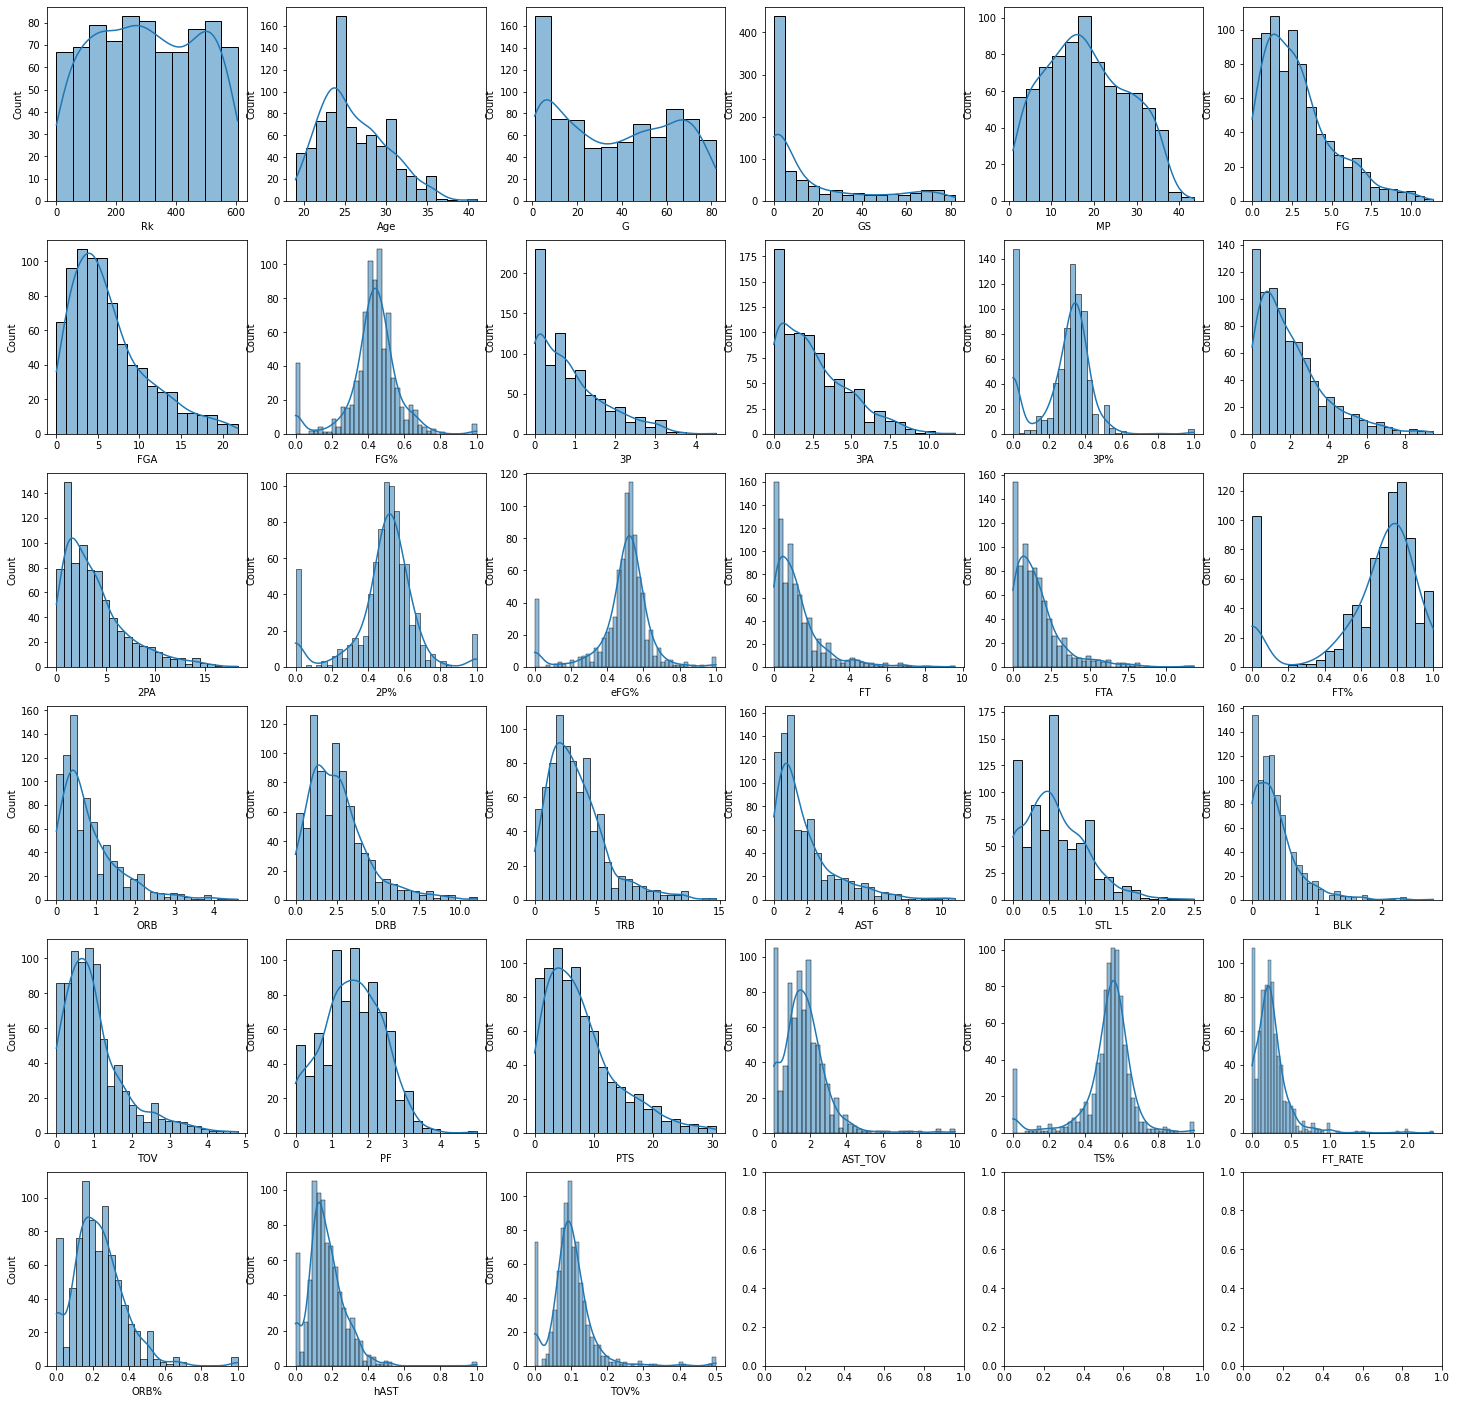

In [102]:
# Define the number of rows and columns you want
n_rows=6
n_cols=6

# Select numerical columns
num = df.select_dtypes(include=['float64', 'int64'])

# Create the subplots
fig, axes = plt.subplots(figsize = (25,25),nrows=n_rows, ncols=n_cols)
for i, column in enumerate(num.columns):
    sns.histplot(num[column],ax=axes[i//n_cols,i%n_cols],kde=True)

In [185]:
# We will create a df removing rank col
df2 = num.drop(['Rk'], axis=1)

# We will scale all variables to have the same weight
scaler = StandardScaler()
features = scaler.fit_transform(df2)


## Cluster Analysis

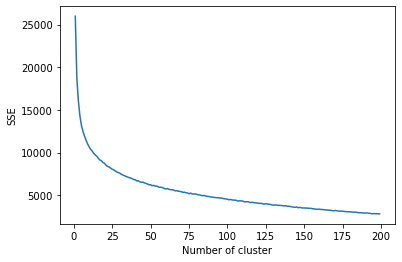

In [141]:
# Fit the model
sse = {}
for k in range(1, 200):
    kmeans = KMeans(n_clusters=k, max_iter=1000,init='k-means++').fit(features)
    features['clusters'] = kmeans.labels_
    #print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [157]:
# We will use 25 clusters as the elbow is not very clear
kmeans = KMeans(n_clusters=25, max_iter=1000,init='k-means++').fit(features)

# We will add the cluster id to the original df
df['ClusterID'] = kmeans.labels_

In [191]:
# We will create a df with the cluster centroids to isnterpret the clusters inferred
cluster_centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_),columns=df2.columns)
cluster_centroids.sort_values(by='PTS',ascending=False)

,Age,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,...,BLK,TOV,PF,PTS,AST_TOV,TS%,FT_RATE,ORB%,hAST,TOV%
6,27.851852,56.592593,5.659259e+01,35.277778,8.659259e+00,18.822222,0.458111,2.396296e+00,6.725926,3.508889e-01,...,4.296296e-01,3.222222,2.222222,24.662963,2.090687e+00,0.574801,3.206367e-01,0.132109,0.212102,0.102334
8,26.842105,56.473684,5.631579e+01,32.652632,7.768421e+00,15.136842,0.514895,1.052632e+00,3.215789,2.971579e-01,...,1.000000e+00,2.600000,2.910526,21.331579,1.567093e+00,0.598462,4.007244e-01,0.233545,0.164247,0.106257
2,25.837209,60.232558,5.676744e+01,32.146512,6.374419e+00,14.125581,0.453395,2.179070e+00,5.846512,3.720698e-01,...,3.930233e-01,1.716279,2.130233,17.560465,1.867904e+00,0.567037,2.340807e-01,0.176377,0.150735,0.083951
11,26.263158,46.631579,4.181579e+01,32.052632,5.178947e+00,12.002632,0.430421,1.765789e+00,5.086842,3.377895e-01,...,4.631579e-01,2.455263,2.428947,14.460526,2.494093e+00,0.542126,2.545504e-01,0.164687,0.271630,0.113580
24,24.814815,63.037037,6.011111e+01,27.962963,4.870370e+00,8.718519,0.572148,5.074074e-01,1.518519,2.177778e-01,...,1.200000e+00,1.374074,2.611111,11.988889,1.463850e+00,0.611181,3.266252e-01,0.318302,0.150064,0.106657
13,27.253521,58.549296,2.664789e+01,26.198592,3.938028e+00,9.447887,0.417479,2.105634e+00,5.661972,3.722113e-01,...,3.253521e-01,1.092958,1.894366,11.269014,1.953511e+00,0.557622,1.681468e-01,0.155798,0.157263,0.080989
12,25.187500,47.375000,1.396875e+01,20.415625,3.840625e+00,6.662500,0.582594,2.562500e-01,0.878125,2.193438e-01,...,8.625000e-01,1.028125,2.328125,9.553125,1.224783e+00,0.625396,3.651688e-01,0.347816,0.127064,0.105557
21,22.540984,55.704918,1.977049e+01,22.821311,3.222951e+00,7.355738,0.444426,9.557377e-01,2.981967,3.287869e-01,...,4.459016e-01,1.047541,1.873770,8.675410,1.572796e+00,0.542932,2.350994e-01,0.238603,0.151362,0.097731
1,30.340909,36.886364,1.079545e+01,19.270455,2.909091e+00,5.786364,0.507136,7.272727e-01,2.022727,3.797045e-01,...,5.613636e-01,0.902273,2.247727,7.586364,1.219293e+00,0.597235,2.478963e-01,0.286682,0.133609,0.105054
5,29.955556,38.422222,7.066667e+00,19.066667,2.373333e+00,5.660000,0.412844,5.822222e-01,1.871111,2.926000e-01,...,2.377778e-01,1.188889,1.677778,6.286667,2.919664e+00,0.503147,2.297420e-01,0.182255,0.323126,0.109267
